# Анализ пользовательского поведения в мобильном приложении

**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

- Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. 

Пользователей разбили на 3 группы:
- 2 контрольные со старыми шрифтами и
- одну экспериментальную — с новыми.

Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества.
- Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. 
- Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. 

Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

In [66]:
import pandas as pd
import numpy as np
from IPython.display import display
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt 
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from statsmodels.stats.weightstats import ztest as ztest
from scipy import stats as st
import numpy as np
import math as mth
from statistics import median
from math import isnan
from scipy import stats as st
import numpy as np
import pandas as pd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


array([[<AxesSubplot:title={'center':'DeviceIDHash'}>,
        <AxesSubplot:title={'center':'EventTimestamp'}>],
       [<AxesSubplot:title={'center':'ExpId'}>, <AxesSubplot:>]],
      dtype=object)

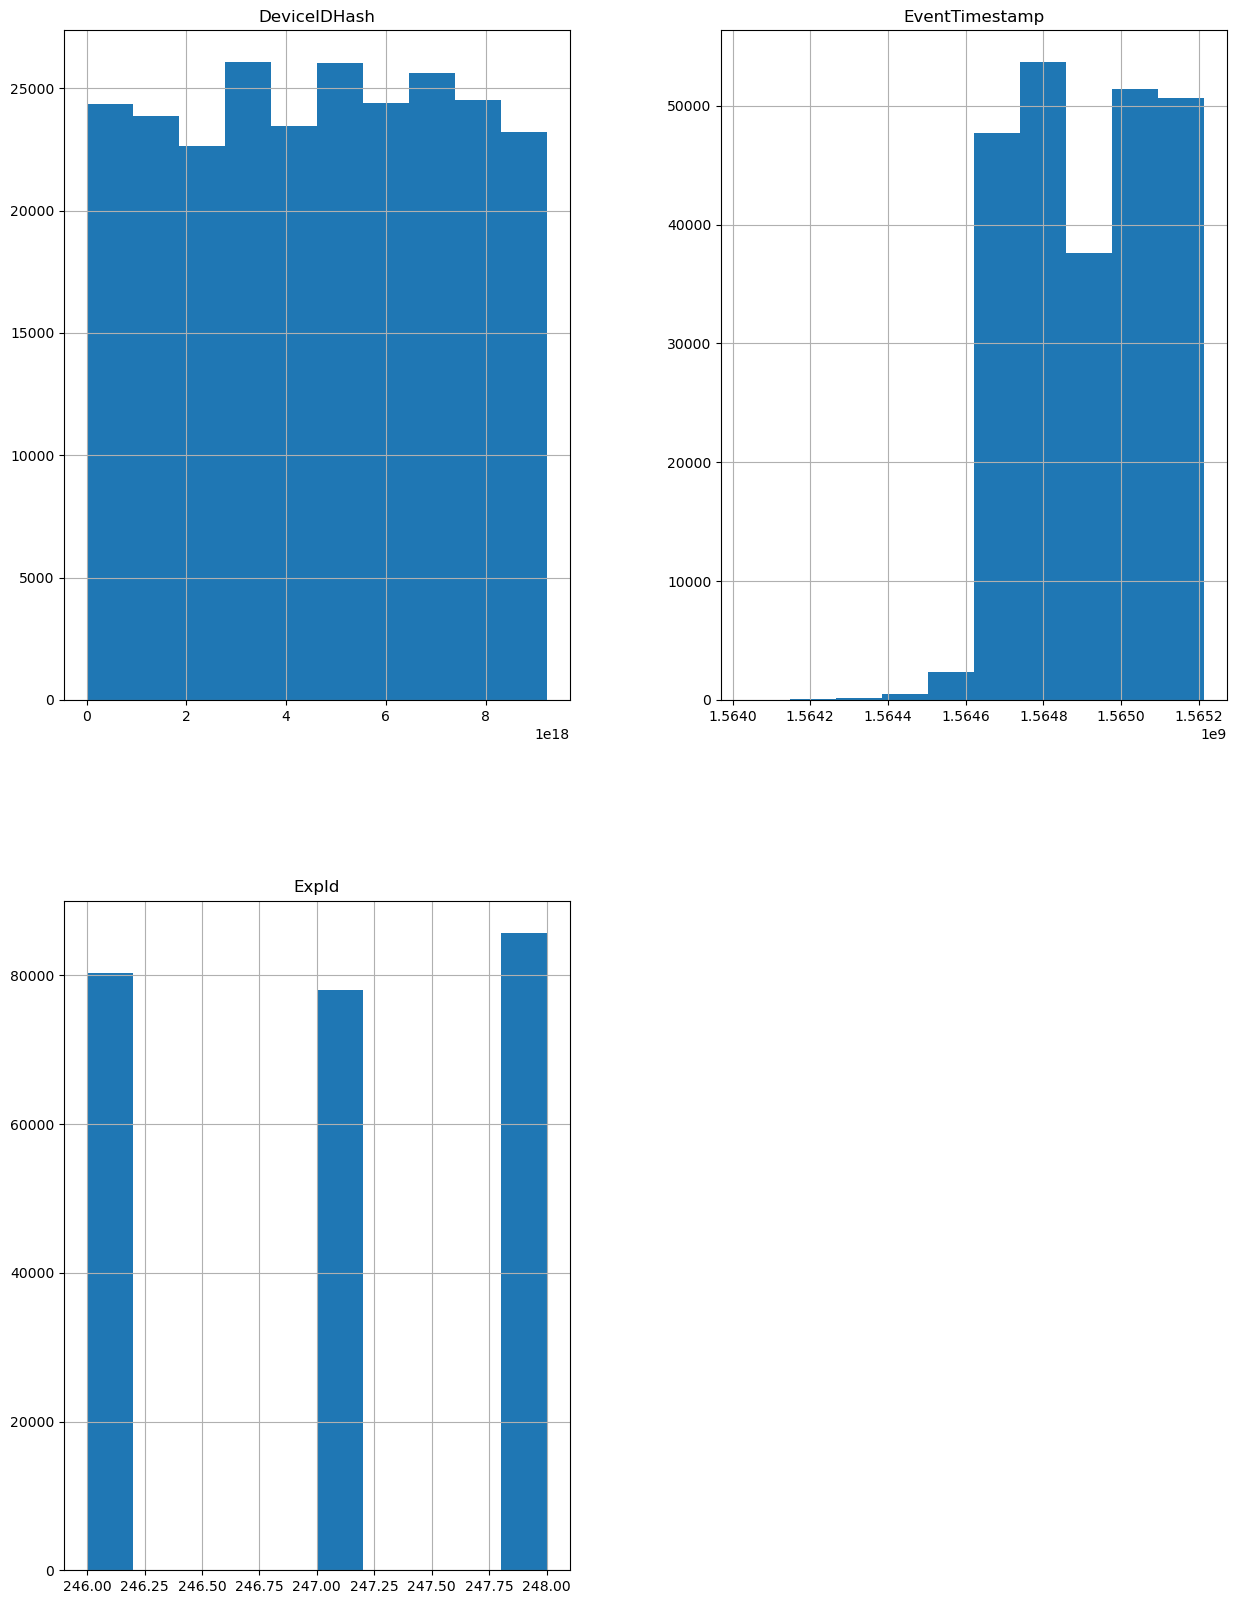

In [67]:
data = pd.read_csv('logs_exp.csv', sep= '\t', decimal='-')   
data.info()
data.hist(figsize=(15, 20))

In [68]:
data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [69]:
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

EventName — название события; 

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [70]:
# переименую столбцы
data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'id', 'EventTimestamp':'time' , 'ExpId':'group' })
data.head(10)

,event_name,id,time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [71]:
# поменяю тип данных в столбце с временем 
data['time'] = data['time'].astype('datetime64[s]')
data.head(10)

,event_name,id,time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246


In [72]:
# проверка данных на дубликаты
data.duplicated().sum()

413

In [73]:
# удалим дубликаты
data = data.drop_duplicates()

In [74]:
#добавим столбец с обозначением контрольных групп и эксперементальной как А1, А2 и В
data['group_1'] = data['group'].replace(246, 'A1')
data['group_1'] = data['group_1'].replace(247, 'A2')
data['group_1'] = data['group_1'].replace(248, 'B')

In [75]:
#добавим столбец даты и времени, а также отдельный столбец дат
data['time'] = pd.to_datetime(data['time'], unit='s')
data['date'] = data['time'].astype('datetime64[D]')

In [76]:
data.sample(5)

,event_name,id,time,group,group_1,date
113414,PaymentScreenSuccessful,4653929188524257097,2019-08-04 07:50:20,247,A2,2019-08-04
13543,OffersScreenAppear,5935355123741815286,2019-08-01 10:06:24,247,A2,2019-08-01
69286,PaymentScreenSuccessful,7311730072021703895,2019-08-02 18:18:39,247,A2,2019-08-02
131504,OffersScreenAppear,250419112136655315,2019-08-04 16:00:03,247,A2,2019-08-04
57,MainScreenAppear,7684943637852660099,2019-07-27 10:25:23,246,A1,2019-07-27


In [77]:
# всего событий в логе
print('Всего событий в логе:', len(data['event_name']))

Всего событий в логе: 243713


In [78]:
print('Всего уникальных типов событий в логе:', len(data['event_name'].unique()))

Всего уникальных типов событий в логе: 5


In [79]:
# всего пользователей в логе
print('Всего уникальных пользователей в логе:', len(data['id'].unique()))

Всего уникальных пользователей в логе: 7551


In [80]:
# Сколько в среднем событий приходится на пользователя
print(f"В среднем на одного пользователя приходится {round(data.groupby('id').agg({'event_name': 'count'}).mean()[0], 1)} события")

В среднем на одного пользователя приходится 32.3 события


In [81]:
# Данные за период 
print('Минимальная дата наблюдений:', data['time'].min())
print('Максимальная дата наблюдений:', data['time'].max())

Минимальная дата наблюдений: 2019-07-25 04:43:36
Максимальная дата наблюдений: 2019-08-07 21:15:17


In [82]:
# максимальная и минимальная даты
print('Минимальная дата наблюдений:', data['time'].min())
print('Максимальная дата наблюдений:', data['time'].max())

Минимальная дата наблюдений: 2019-07-25 04:43:36
Максимальная дата наблюдений: 2019-08-07 21:15:17


Text(0, 0.5, 'количество пользователей')

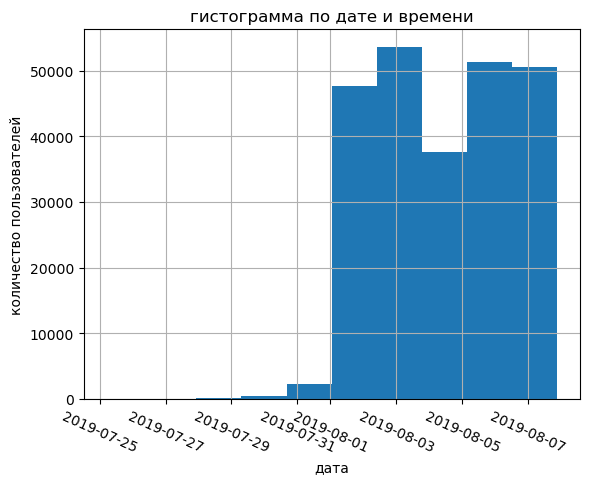

In [83]:
# гистограмма по дате и времени
import pandas as pd
import matplotlib.pyplot as plt 
data['time'].hist()
plt.xticks(rotation=14*24)
plt.title("гистограмма по дате и времени")
plt.xlabel("дата")
plt.ylabel("количество пользователей")

In [84]:
# отбрасываем старые данные
data_1 = data.query('time >= "2019-08-01"')
print('Новая минимальная дата наблюдений:', data['time'].min())

Новая минимальная дата наблюдений: 2019-07-25 04:43:36


Данными за какой период времени вы располагаете на самом деле?
- с 2019-08-01 00:07:28 по 2019-08-07 21:15:17 ( то есть неделя)

In [85]:
data.sample(5)

,event_name,id,time,group,group_1,date
49762,MainScreenAppear,6900144526870080372,2019-08-02 09:24:21,246,A1,2019-08-02
177928,CartScreenAppear,1535501606752467083,2019-08-06 03:01:26,247,A2,2019-08-06
226366,MainScreenAppear,1763234204193593145,2019-08-07 11:54:07,247,A2,2019-08-07
118380,MainScreenAppear,3655006604929276292,2019-08-04 10:20:24,248,B,2019-08-04
103545,MainScreenAppear,5185216071806774842,2019-08-03 18:12:07,246,A1,2019-08-03


In [86]:
data_min = '2019-08-01 00:07:28'

In [87]:
non_actual = data.loc[(data['time'] <= data_min)]
display(non_actual['time'].min())
display(non_actual['time'].max())

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-01 00:07:28')

In [88]:
# всего событий в логе
print('Всего событий в логе:', len(data['event_name']))

Всего событий в логе: 243713


In [89]:
# количество событий
print('Потерянных событий: ' , non_actual['time'].count())

Потерянных событий:  2827


In [90]:
# всего пользователей в логе
print('Всего уникальных пользователей в логе:', len(data['id'].unique()))

Всего уникальных пользователей в логе: 7551


In [91]:
print('Всего уникальных пользователей в логе после отчистки:', len(data_1['id'].unique()))

Всего уникальных пользователей в логе после отчистки: 7534


In [92]:
#Доля потеряных событий
print('Потерянных событий:  ', (non_actual['event_name'].count() / data['event_name'].count()))

Потерянных событий:   0.011599709494364273


In [93]:
#доля потеряных пользователей 
print('Количество потерянных пользователей:',data['id'].nunique()-data_1['id'].nunique())

print('Процент потерь пользователей:', round(100-data_1['id'].nunique()/data['id'].nunique()*100, 2), '%')

Количество потерянных пользователей: 17
Процент потерь пользователей: 0.23 %


In [94]:
#найдем минимальную и максимальную дату
firts_date = data['time'].min()
last_date = data['time'].max()

#найдем разницу между первой и последней датой, т.е. период
difference = last_date - firts_date
print('Данные от %s до %s, разница в %s.' % (firts_date, last_date, difference))

Данные от 2019-07-25 04:43:36 до 2019-08-07 21:15:17, разница в 13 days 16:31:41.


In [95]:
print('Число пользователей в группе 246:', len(data[data['group'] == 246]))

Число пользователей в группе 246: 80181


In [96]:
print('Число пользователей в группе 247:', len(data[data['group'] == 247]))

Число пользователей в группе 247: 77950


In [97]:
print('Число пользователей в группе 248:', len(data[data['group'] == 248]))

Число пользователей в группе 248: 85582


In [98]:
data.groupby('id').agg({'group': 'nunique'}).query('group > 1')

,group
id,


In [99]:
events_count = data_1.groupby('event_name').agg({'id': 'count'})
events_count

,id
event_name,
CartScreenAppear,42303
MainScreenAppear,117328
OffersScreenAppear,46333
PaymentScreenSuccessful,33918
Tutorial,1005


MainScreenAppear (главный экран) 
>
OffersScreenAppear (экран предложения)
> 
CartScreenAppear (корзина)
>
PaymentScreenSuccessful (страница успешной оплаты) 



Tutorial (руководство) редко используется пользователями.

In [100]:
events_count.sort_values(by='id', ascending=False)

,id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [101]:
# оценим количество уникальных пользователей на каждом этапе
users_count = data_1.groupby('event_name').agg({'id': 'nunique'}).sort_values(by='id', ascending=False)

In [102]:
# добавим столбец со значениями доли в процентах
users_count['percentages'] = users_count['id'] / data['id'].nunique()
users_count = users_count.round(1)
users_count

,id,percentages
event_name,,
MainScreenAppear,7419,1.0
OffersScreenAppear,4593,0.6
CartScreenAppear,3734,0.5
PaymentScreenSuccessful,3539,0.5
Tutorial,840,0.1


пользователи начинают с главного экрана (MainScreenAppear),

переходят на экран с предложенными товарами (OffersScreenAppear),

если его заинтересовало что-то, то он отправляется в корзину (CartScreenAppear) 

и оплачивает покупку (PaymentScreenSuccessful).


Еще есть обучение (Tutorial), предположим приложение простое и интуитивно понятное, поэтомуо пользователи пропускают его
можно не учитывать при расчете воронки

In [103]:
users_count

,id,percentages
event_name,,
MainScreenAppear,7419,1.0
OffersScreenAppear,4593,0.6
CartScreenAppear,3734,0.5
PaymentScreenSuccessful,3539,0.5
Tutorial,840,0.1


In [104]:
# data_conv['конверсия'] = data_conv['количество пользователей']/data_conv['количество пользователей'].shift(1)
data_conv = users_count['id']/users_count['id'].shift(1)
data_conv.round(1)

event_name
MainScreenAppear           NaN
OffersScreenAppear         0.6
CartScreenAppear           0.8
PaymentScreenSuccessful    0.9
Tutorial                   0.2
Name: id, dtype: float64

In [105]:
users_count['%'] = round(users_count['id'] / 
                                     users_count['id']
                                     .shift(periods=1, fill_value=1*users_count['id'][0]), 3).round(1)
display(users_count)

,id,percentages,%
event_name,,,
MainScreenAppear,7419,1.0,1.0
OffersScreenAppear,4593,0.6,0.6
CartScreenAppear,3734,0.5,0.8
PaymentScreenSuccessful,3539,0.5,0.9
Tutorial,840,0.1,0.2


На каком шаге теряем больше всего пользователей?
- OffersScreenAppear

От первого события до оплаты доходит 47.7% пользователей.

                            Изучите результаты эксперимента 

In [106]:
data_1

,event_name,id,time,group,group_1,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,A1,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,A1,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,A1,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,A1,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,A2,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,A2,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,A1,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,A1,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,A1,2019-08-07


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. 

Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.


Критерии успешного A/A-теста: 

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. 
- Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [107]:
# Сколько пользователей в каждой экспериментальной группе
users = data_1.groupby('group_1')['id'].nunique().reset_index()
users

,group_1,id
0,A1,2484
1,A2,2513
2,B,2537


находят ли статистические критерии разницу между выборками 246 и 247

In [108]:
#число пользователей в каждой группе
users_A1 = int(users[users['group_1'] == 'A1']['id'])
users_A2 = int(users[users['group_1'] == 'A2']['id'])
print('Количество пользователей в группах различается на', round(100 - (users_A1 / users_A2 * 100), 2), '%')

Количество пользователей в группах различается на 1.15 %


In [109]:
users_group = data_1.groupby('group_1')['id'].nunique()
users_group['A1+A2'] = users_group['A1'] + users_group['A2']
users_group

group_1
A1       2484
A2       2513
B        2537
A1+A2    4997
Name: id, dtype: int64

всё примерно в равных пропорциях

                                            Гипотезы

метод Бонферрони (поправка Бонферрони)

будем проводить 16 сравнений, следовательно, bonferroni_alpha будет равно alpha / 16

Сформулируем гипотезы:

H0: Конверсия пользователей в обеих группах равна

H1: Конверсия в обеих группах не равна


In [110]:
test = data[data['event_name']!='Tutorial'].pivot_table(
    index='event_name', 
    columns='group_1', 
    values='id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

In [111]:
test = test.reset_index()
test['A1+A2'] = test['A1'] + test['A2']
test['all'] = test['A1+A2'] + test['B']

In [112]:
test['t_A1'] = (test['A1'] / users_group['A1'] * 100).round(1)
test['t_A2'] = (test['A2'] / users_group['A2'] * 100).round(1)
test['t_B'] = (test['B'] / users_group['B'] * 100).round(1)
test['t_A1+A2'] = ((test['A1'] + test['A2']) / \
                                  (users_group['A1'] + users_group['A2']) * 100).round(1)

test

group_1,event_name,A1,A2,B,A1+A2,all,t_A1,t_A2,t_B,t_A1+A2
0,MainScreenAppear,2456,2482,2501,4938,7439,98.9,98.8,98.6,98.8
1,OffersScreenAppear,1545,1530,1538,3075,4613,62.2,60.9,60.6,61.5
2,CartScreenAppear,1270,1240,1239,2510,3749,51.1,49.3,48.8,50.2
3,PaymentScreenSuccessful,1202,1160,1185,2362,3547,48.4,46.2,46.7,47.3


In [113]:
def z_test(group1, group2, alpha):
    for i in test.index:
        p1 = test[group1][i] / users_group[group1]
        # пропорция успехов во второй группе:
        p2 = test[group2][i] / users_group[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((test[group1][i] + test[group2][i]) / 
                      (users_group[group1] + users_group[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_group[group1] + 1/users_group[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
z_test("A1", "A2", 0.01)

MainScreenAppear p-значение: 0.7277981031869922
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.339535456222523
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.20732661451375378
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11444799639438141
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [114]:
z_test("A1", "B", 0.05)

MainScreenAppear p-значение: 0.35679078059641833
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2516401615442403
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.10467819661731759
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.23306313092262299
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [115]:
z_test("A2", "B", 0.05)

MainScreenAppear p-значение: 0.5647603013034597
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8495891033265146
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.7190102791382327
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6958376455470208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [116]:
z_test("A1+A2", "B", 0.05)

MainScreenAppear p-значение: 0.38101790528106605
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44151875094142534
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2531263003615689
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6455674330516254
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Вывод: Значимой разницы между группами во всех тестах не выявлено

В ходе тестирования были проведены 16 экспериментов:

- A1/A1 - 4 эксперемента (для каждого события) / уровень статистической значимости - 1%

- A1/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%

- A2/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%

- A1+A2/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%


для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными

In [117]:
test

group_1,event_name,A1,A2,B,A1+A2,all,t_A1,t_A2,t_B,t_A1+A2
0,MainScreenAppear,2456,2482,2501,4938,7439,98.9,98.8,98.6,98.8
1,OffersScreenAppear,1545,1530,1538,3075,4613,62.2,60.9,60.6,61.5
2,CartScreenAppear,1270,1240,1239,2510,3749,51.1,49.3,48.8,50.2
3,PaymentScreenSuccessful,1202,1160,1185,2362,3547,48.4,46.2,46.7,47.3


In [118]:
data_1

,event_name,id,time,group,group_1,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,A1,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,A1,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,A1,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,A1,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,A2,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,A2,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,A1,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,A1,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,A1,2019-08-07


In [119]:
users_group

group_1
A1       2484
A2       2513
B        2537
A1+A2    4997
Name: id, dtype: int64

In [120]:
test_1 = data_1.pivot_table(
    index='event_name', 
    columns='group_1', 
    values='id',
    aggfunc='nunique')
test_1 = test_1.reset_index()
test_1

group_1,event_name,A1,A2,B
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [121]:
test_2 = test_1
test_2 = test_2.rename(columns={'A1':'246', 'A2':'247', 'B':'248' })
test_2

group_1,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [122]:
test_2[222] = test['A1+A2']
test_2

group_1,event_name,246,247,248,222
0,CartScreenAppear,1266,1238,1230,4938.0
1,MainScreenAppear,2450,2476,2493,3075.0
2,OffersScreenAppear,1542,1520,1531,2510.0
3,PaymentScreenSuccessful,1200,1158,1181,2362.0
4,Tutorial,278,283,279,NaN


In [123]:
data_new = data_1.groupby('group')['id'].nunique()
data_new[222] = data_new[246]+data_new[247]
data_new

group
246    2484
247    2513
248    2537
222    4997
Name: id, dtype: int64

In [124]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha): 
    
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    p_combined = (successes1 + successes2) / (trials1 + trials2) 
    difference = p1 - p2
    
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(' уровень значимости :', p_value)
    print(' уровень значимости :', alpha)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
         

    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [125]:
for events in test_2.index:
    check_hypothesis(test_2.loc[events, '246'], test_2.loc[events,'247'],
         data_new[246], data_new[247], 0.05)
    print()

 уровень значимости : 0.22883372237997213
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.7570597232046099
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.2480954578522181
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.11456679313141849
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.9376996189257114
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу



In [126]:
for events in test_2.index:
    check_hypothesis(test_2.loc[events, '247'], test_2.loc[events,'248'],
         data_new[247], data_new[248], 0.05)
    print()

 уровень значимости : 0.5786197879539783
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.4587053616621515
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.9197817830592261
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.7373415053803964
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.765323922474501
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу



In [127]:
for events in test_2.index:
    check_hypothesis(test_2.loc[events, '246'], test_2.loc[events,'248'],
         data_new[246], data_new[248], 0.05)
    print()

 уровень значимости : 0.07842923237520116
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.2949721933554552
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.20836205402738917
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.2122553275697796
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : 0.8264294010087645
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу



In [128]:
for events in test_2.index:
    check_hypothesis(test_2.loc[events, 222], test_2.loc[events,'248'],
         data_new[222], data_new[248], 0.05)
    print()

 уровень значимости : 0.0
 уровень значимости : 0.05
Отвергаем нулевую гипотезу

 уровень значимости : 0.0
 уровень значимости : 0.05
Отвергаем нулевую гипотезу

 уровень значимости : 0.0
 уровень значимости : 0.05
Отвергаем нулевую гипотезу

 уровень значимости : 0.555500175123987
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу

 уровень значимости : nan
 уровень значимости : 0.05
Не получилось отвергнуть нулевую гипотезу



**Выводы**

- изменение шрифта не повлияло на поведение пользователей
- Наиболее полными являются данные за период с 1 по 7 августа 2019 года
- типы событий в логах: 
MainScreenAppear, 
OffersScreenAppear,
CartScreenAppear, 
PaymentScreenSuccessful. 
Чаще всего из них встречается MainScreenAppear (главный экран)
- пользователи начинают с главного экрана (MainScreenAppear), 
переходят на экран с предложенными товарами (OffersScreenAppear), корзина (CartScreenAppear) и оплата покупки (PaymentScreenSuccessful)
